In [1]:
from sklearn.dummy import DummyClassifier
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from typing import Type
from torch.optim import lr_scheduler
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss,Conv2d,MaxPool2d
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
import sys
import random
import copy
import time
import shutil
import pickle
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from pandas import DataFrame
import seaborn as sn
import numpy as np
import PIL
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from ipynb.fs.full._3_prepare_tracked_datasets import Char,Poly,Point,CustomUnpickler
from ipynb.fs.full._2_emnist_analyze import LeNet,MyResNet,BasicBlock,Trainer

0
None
0
None
0


/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/jupyter_venvs/mipt_venv/lib64/python3.11/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/d.yacenko/work/Dissertation/_2_emnist_analyze.ipynb:231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is p

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
BATCH_SIZE=50
EPOCHS=10
ACTIVATE="relu"
DROPOUT=True
BATCHNORM=True
TRACK_MAX_LEN=30
CURRENT_FOLDER="./"
DATASET_VARIANT="byclass"
tr=Trainer()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

load dataset

In [5]:
f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict_UJI.p'), 'rb')
f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict_UJI.p'), 'rb')
TRAIN_DICT = CustomUnpickler(f_train_dict).load()
TEST_DICT = CustomUnpickler(f_test_dict).load()
f_train_dict.close()
f_test_dict.close()

In [6]:
# print(TRAIN_DICT)
# print(TEST_DICT)
CHAR_LIST=list(TRAIN_DICT.keys())
CHAR_LIST.sort()
print("Классов: {}".format(len(list(TRAIN_DICT.keys()))))
print(list(TRAIN_DICT.keys()).sort())
all_size=0
for key in TRAIN_DICT.keys():
  all_size+=len(TRAIN_DICT[key])

Классов: 62
None


In [7]:
all_size,TRAIN_DICT.keys()

(5913,
 dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'P', 'Q', 'S', 'T', 'U', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'i', 'j', 'o', 'N', 'O', 'R', 'V']))

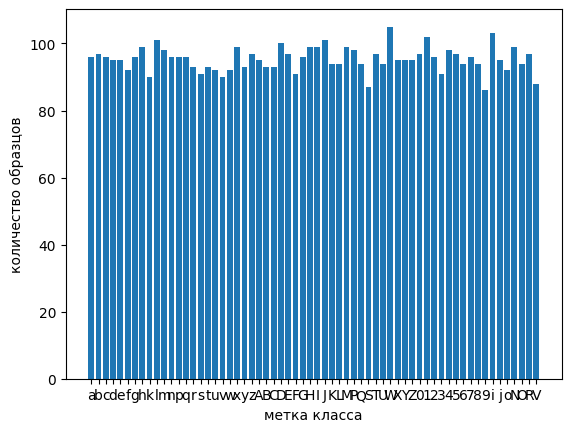

In [8]:
if __name__ == "__main__":
    plt.bar( TRAIN_DICT.keys(),[len(TRAIN_DICT[key]) for key in TRAIN_DICT.keys()])
    plt.xlabel("метка класса")
    plt.ylabel("количество образцов")

Single track length max:3353.0; min:123.0; avg:784.1858616607475
Single track length>1500: 128


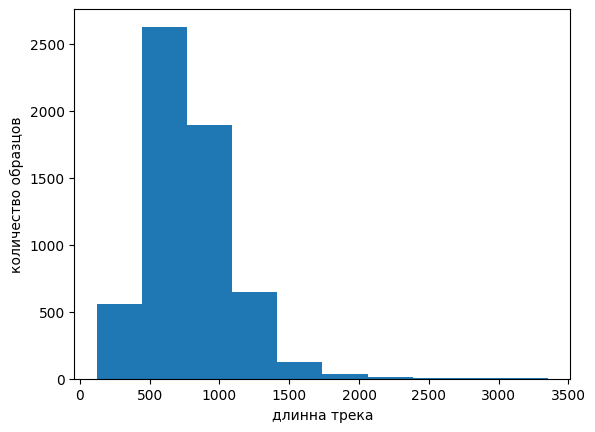

In [9]:
if __name__ == "__main__":
    data=TRAIN_DICT
    rez=np.array([])
    for key in data.keys():
        for ch in data[key]:
            rez=np.append(rez,len(ch.singlePolys().fft_angles))
    print("Single track length max:{}; min:{}; avg:{}".format(max(rez),min(rez),sum(rez)/len(rez)))  
    print("Single track length>{}: {}".format(1500,sum(rez>1500)))
    plt.hist(rez)
    plt.xlabel("длинна трека")
    plt.ylabel("количество образцов")
    plt.savefig("images/uji_tracks_fft_disp.png",  bbox_inches='tight', pad_inches=0)

30


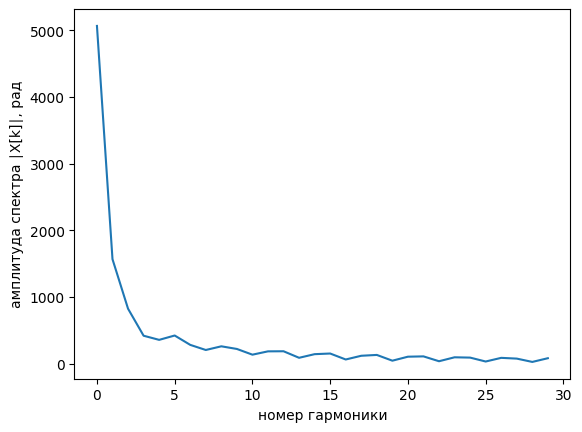

In [10]:
if __name__ == "__main__":
    data=TRAIN_DICT['a'][0].singlePolys().fft_angles[:TRACK_MAX_LEN]
    print(len(data))
    plt.plot(range(len(data)),data)
    plt.xlabel("номер гармоники")
    plt.ylabel("амплитуда спектра ∣X[k]∣, рад")
    plt.savefig("images/uji_a_char_fft_angles_change.png",  bbox_inches='tight', pad_inches=0)

In [11]:
class DynDataset(Dataset):

    def __init__(self, data, transform=None, data_type='fft_angles',track_max_len=TRACK_MAX_LEN):
        str="0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
        self.type=data_type
        self.track_max_len=track_max_len
        self.data=np.array([])
        for key in data.keys():
            for ch in data[key]:
                if key in str:
                    self.data=np.append(self.data,[ch])              
        self.classes=list(str)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_ix = np.zeros([self.track_max_len], dtype='float32')
        if self.type=='angles':
            vec=self.data[idx].singlePolys().angles
        elif self.type=='speed':
            vec=self.data[idx].singlePolys().speeds
        elif self.type=='fft_angles':
            vec=self.data[idx].singlePolys().fft_angles
        else:
            vec=self.data[idx].singlePolys().fft_speeds  
        # ограничим длинну трека
        data_ix[:len(vec)] = vec[:self.track_max_len]
        class_num=self.classes.index(self.data[idx].name)
        return torch.Tensor(data_ix),class_num

In [12]:
vec_datasets = {"train": DynDataset(TRAIN_DICT, data_type='fft_angles'),
                 "val":DynDataset(TEST_DICT, data_type='fft_angles')}
dataloaders = {"train": torch.utils.data.DataLoader(vec_datasets["train"], batch_size=BATCH_SIZE,shuffle=True),
               "val": torch.utils.data.DataLoader(vec_datasets["val"], batch_size=BATCH_SIZE,shuffle=True),
}
dataset_sizes = {x: len(vec_datasets[x]) for x in ['train', 'val']}
classes_names = {x: vec_datasets[x].classes for x in ['train', 'val']}

torch.Size([3, 50, 30])


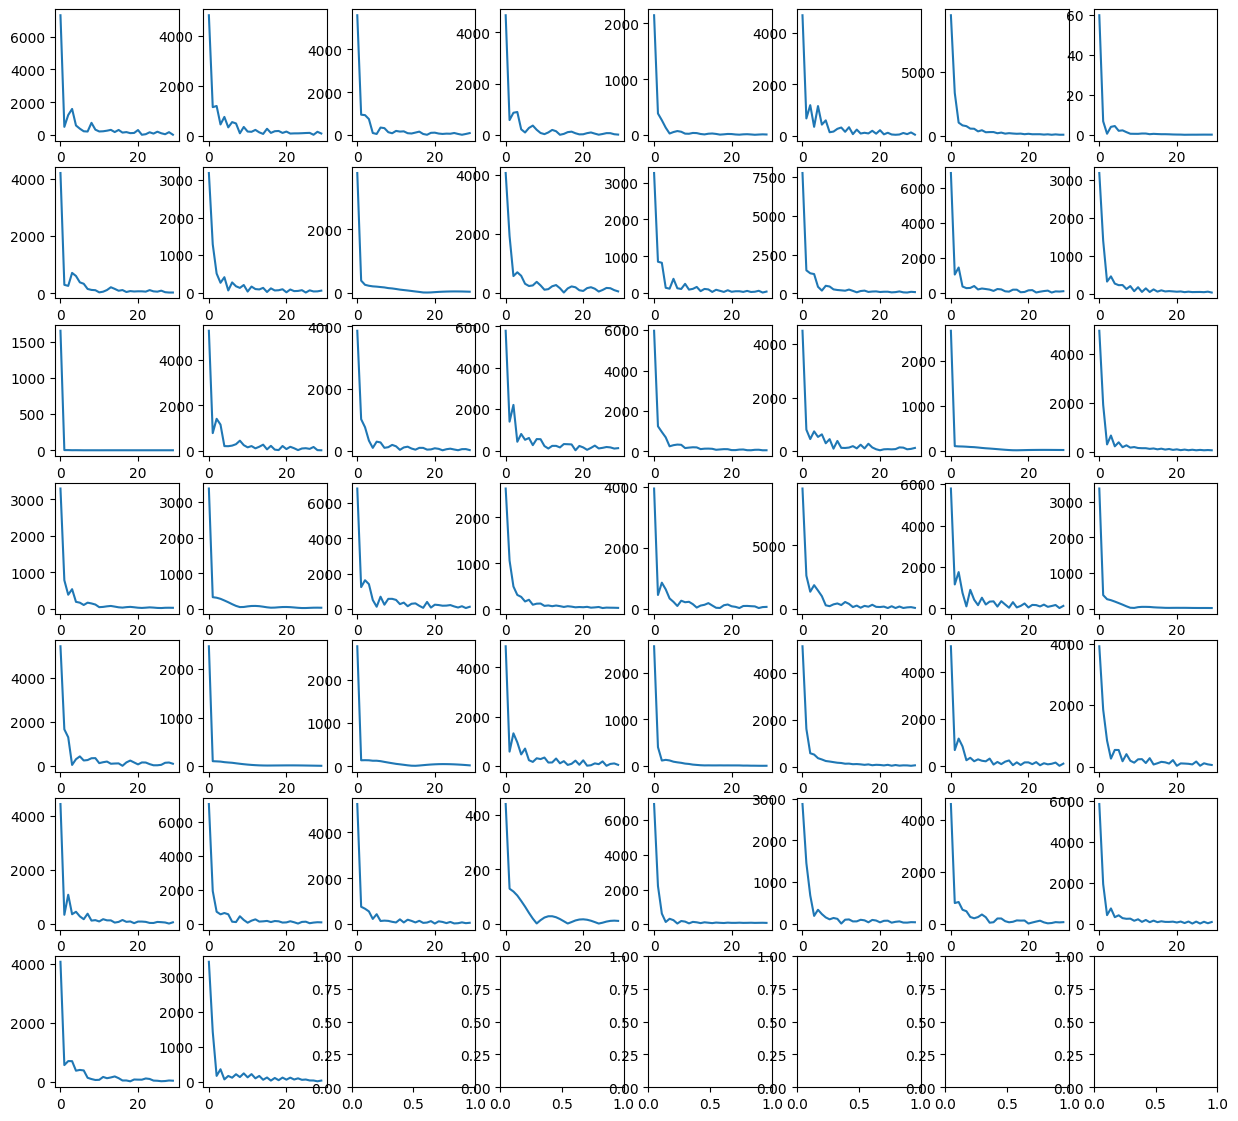

    a     n     q     y     x     9     b     5     7     7     t     e     4     b     D     U     M     m     E     5     q     M     I     t     3     F     W     c     5     y     d     H     z     R     Y     3     s     Q     a     v     9     R     3     x     f     T     H     U     5     r


In [13]:
from math import sqrt

def imshow(img):
    n=int(sqrt(BATCH_SIZE))+1
    npimg = img.numpy()
    img=npimg[0]
    figure, axis = plt.subplots(n-1, n,figsize=(15, 14))
    count=0
    for j in range(n):
        for i in range(n):
            if count<img.shape[0]:
                axis[j, i].plot(range(TRACK_MAX_LEN),img[count])
            count+=1
    plt.savefig("images/uji_images_fft_angles.png",  bbox_inches='tight', pad_inches=0)      
    plt.show()
    
if __name__ == "__main__":
    # Get a batch of training data
    image, label = next(iter(dataloaders['val']))
    out = torchvision.utils.make_grid(image)
    print(out.shape)
    imshow(torchvision.utils.make_grid(out))
    str=' '.join('%5s' % vec_datasets['val'].classes[label[j]] for j in range(BATCH_SIZE))
    print(str)
    with open('images/uji_fft_angles_lbl.txt', 'w') as f:
        f.write(str)

create model

In [14]:
class FNNCell(torch.nn.Module):
    def __init__(self,channel=1,track_max_len=TRACK_MAX_LEN,num_classes=len(CHAR_LIST),activate=ACTIVATE):
        super(FNNCell, self).__init__()
        self.SHOW=0
        self.layers=torch.nn.ModuleList()  

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Linear(track_max_len, 256))
        l.append(Trainer.getActivateFunction(activate))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=1))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Linear(256, 128))
        l.append(Trainer.getActivateFunction(activate))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=1))

       
        self.flat = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(128,num_classes)
        
    def forward(self, x):
        x = self._forward(x)      
        x = self.fc1(x)
        return x

    def _forward(self, x):
        n=1 
        x =  x[:,None,:]

        for layer in self.layers:
          for elem in layer:
            x=elem(x)
            if self.SHOW==0: print("--->   {}".format(x.shape))   
          n+=1 
          if self.SHOW==0: print("====")  
        self.SHOW+=1
        # x = self.ga(x)
        x = self.flat(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        return x
    
    def _inference(self, x):
        x = self._forward(x)
        return x    

FCNN

In [15]:
net=FNNCell(track_max_len=TRACK_MAX_LEN,num_classes=len(vec_datasets["train"].classes)).to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

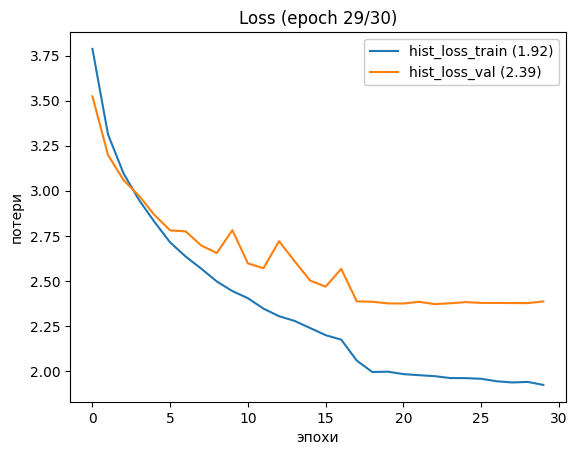

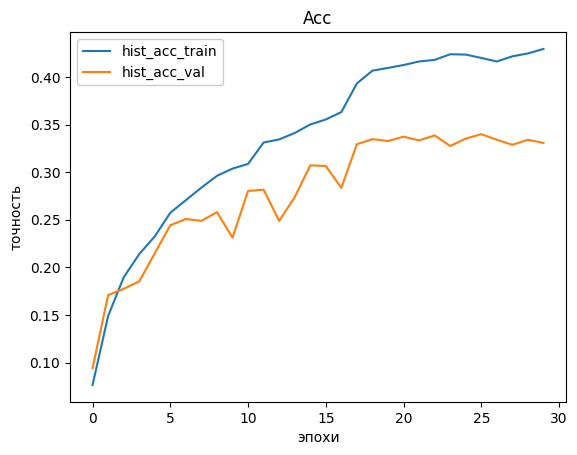

Train time:37.995386838912964
Best acc:0.3385723641126392


In [17]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=30, net_name="FNNCell_uji_fft_angles")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

In [18]:
if __name__ == "__main__":
    torch.save(model.state_dict(), "models/uji_fft_fcnet_"+DATASET_VARIANT+".pt")
    model.load_state_dict(torch.load("models/uji_fft_fcnet_"+DATASET_VARIANT+".pt"))

<All keys matched successfully>

RNN2

In [19]:
class RNN2Cell(nn.Module):

    def __init__(self, bidirectional=True, track_max_len=TRACK_MAX_LEN,
                 num_classes=len(CHAR_LIST),  rnn_num_units=1024):
        super(self.__class__, self).__init__()
        self.track_max_len=track_max_len
        self.num_units = rnn_num_units
        self.num_layers = 3
        self.rnn = nn.RNN(1,
                          self.num_units,
                          num_layers=self.num_layers,
                          batch_first=True,
                          bidirectional=bidirectional,
                          dropout=0.05
                         )
        self.rnn_to_logits = nn.Linear(self.num_units*2 if bidirectional else self.num_units, num_classes)

    def forward(self, x):
        # x = torch.transpose(x,0,1)
        x=x[:,:,None]
        output, _ = self.rnn(x)
        logits = self.rnn_to_logits(output[:,-1,:])
        return logits # только последний элемент в цепочке


In [20]:
net=RNN2Cell(track_max_len=TRACK_MAX_LEN,num_classes=len(vec_datasets["train"].classes)).to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

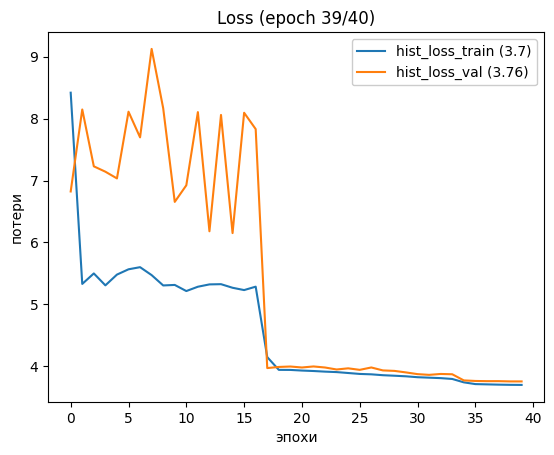

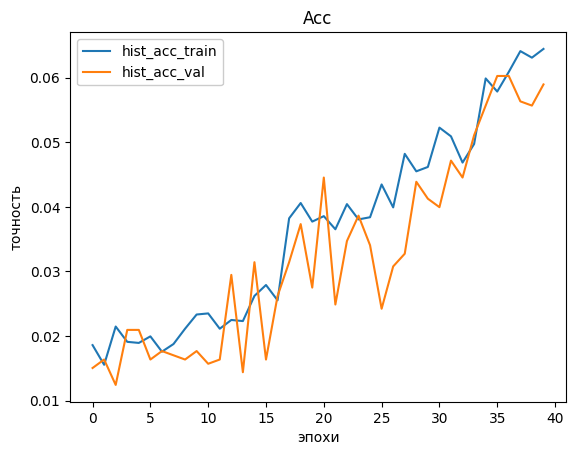

Train time:600.6455600261688
Best acc:0.05893909626719057


In [22]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=40, net_name="RNN2Cell_uji_fft_angles")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

LSTM

In [14]:
class LSTMCell(nn.Module):

    def __init__(self, bidirectional=True, track_max_len=TRACK_MAX_LEN,
                 num_classes=len(CHAR_LIST),  rnn_num_units=1024):
        super(self.__class__, self).__init__()
        self.track_max_len=track_max_len
        self.num_units = rnn_num_units
        self.num_layers = 3
        self.rnn = nn.LSTM(1,
                          self.num_units,
                          num_layers=self.num_layers,
                          batch_first=True,
                          bidirectional=bidirectional,
                          dropout=0.05
                          )
       
        self.rnn_to_logits = nn.Linear(self.num_units*2 if bidirectional else self.num_units, num_classes)


    def forward(self, x):
        x=x[:,:,None]
        output, _ = self.rnn(x)
        logits = self.rnn_to_logits(output[:,-1,:])
        return logits # только последний элемент в цепочке

In [15]:
net=LSTMCell(track_max_len=TRACK_MAX_LEN,num_classes=len(vec_datasets["train"].classes)).to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

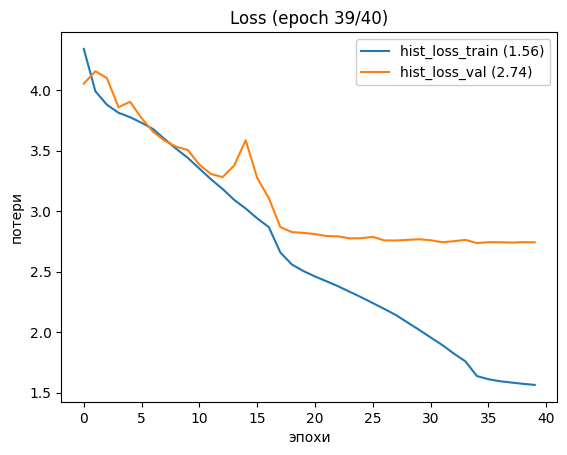

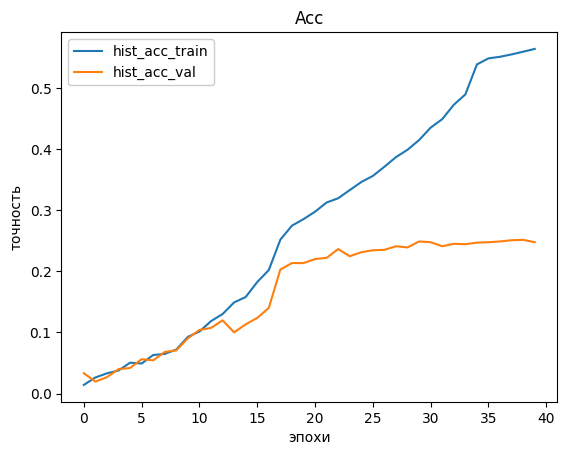

Train time:2098.291327238083
Best acc:0.24688932547478717


In [17]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=40, net_name="LSTMCell_uji_fft_angles")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

CNN

In [27]:
class CNNCell(torch.nn.Module):
    def __init__(self,channel=1,num_classes=len(CHAR_LIST),activate=ACTIVATE):
        super(CNNCell, self).__init__()
        self.SHOW=0
        self.layers=torch.nn.ModuleList()  

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(1, 20, 3))
        l.append(Trainer.getActivateFunction(activate))
        l.append(torch.nn.MaxPool1d(2))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=20))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(20, 30, 3))
        l.append(Trainer.getActivateFunction(activate))
        l.append(torch.nn.MaxPool1d(2))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=30))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(30, 40, 3))
        l.append(Trainer.getActivateFunction(activate))
        l.append(torch.nn.MaxPool1d(3))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=40))

        self.ga = torch.nn.AdaptiveMaxPool1d(3)
        self.flat = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(3*40,num_classes)

        
    def forward(self, x):
        x = self._forward(x)      
        x = self.fc1(x)
        return x

    def _forward(self, x):
        n=1 
        x =  x[:,None,:]

        for layer in self.layers:
          for elem in layer:
            x=elem(x)
            if self.SHOW==0: print("--->   {}".format(x.shape))   
          n+=1 
          if self.SHOW==0: print("====")  
        self.SHOW+=1
        x = self.ga(x)
        x = self.flat(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        #x = self.sm(x)
        return x
    
    def _inference(self, x):
        x = self._forward(x)
        #x = self.sm(x)
        return x

In [28]:
net=CNNCell(num_classes=len(vec_datasets["train"].classes)).to(device)

train

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

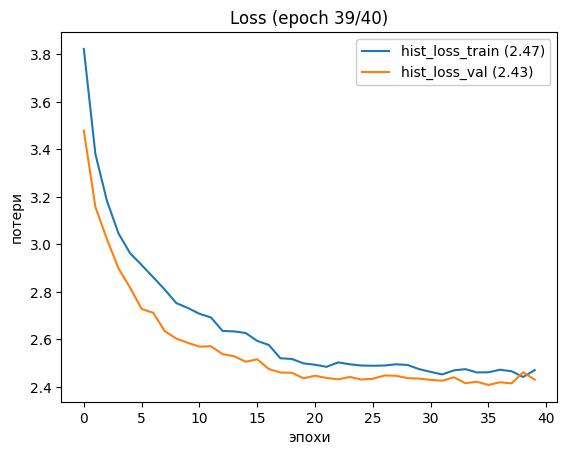

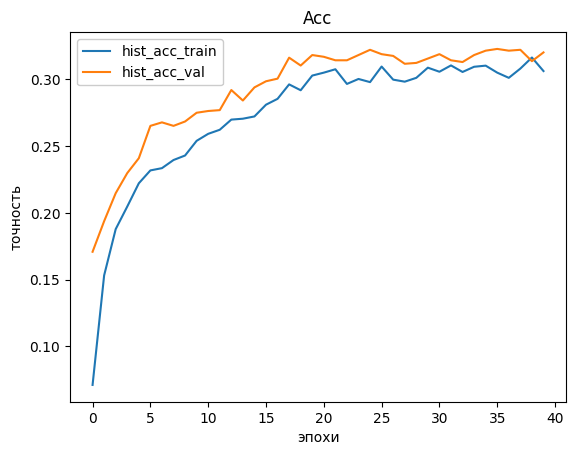

Train time:70.07611274719238
Best acc:0.3228552717747217


In [30]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=40, net_name="CNNCell_uji_fft_angles")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

analyze

In [31]:
if __name__ == "__main__":
    _preds=np.array([])
    _targets=np.array([])
    for inputs, labels in dataloaders['val']:    # Iterate over data.
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        _targets=np.append(_targets, labels.detach().cpu().numpy())
        _preds=np.append(_preds,preds.detach().cpu().numpy())


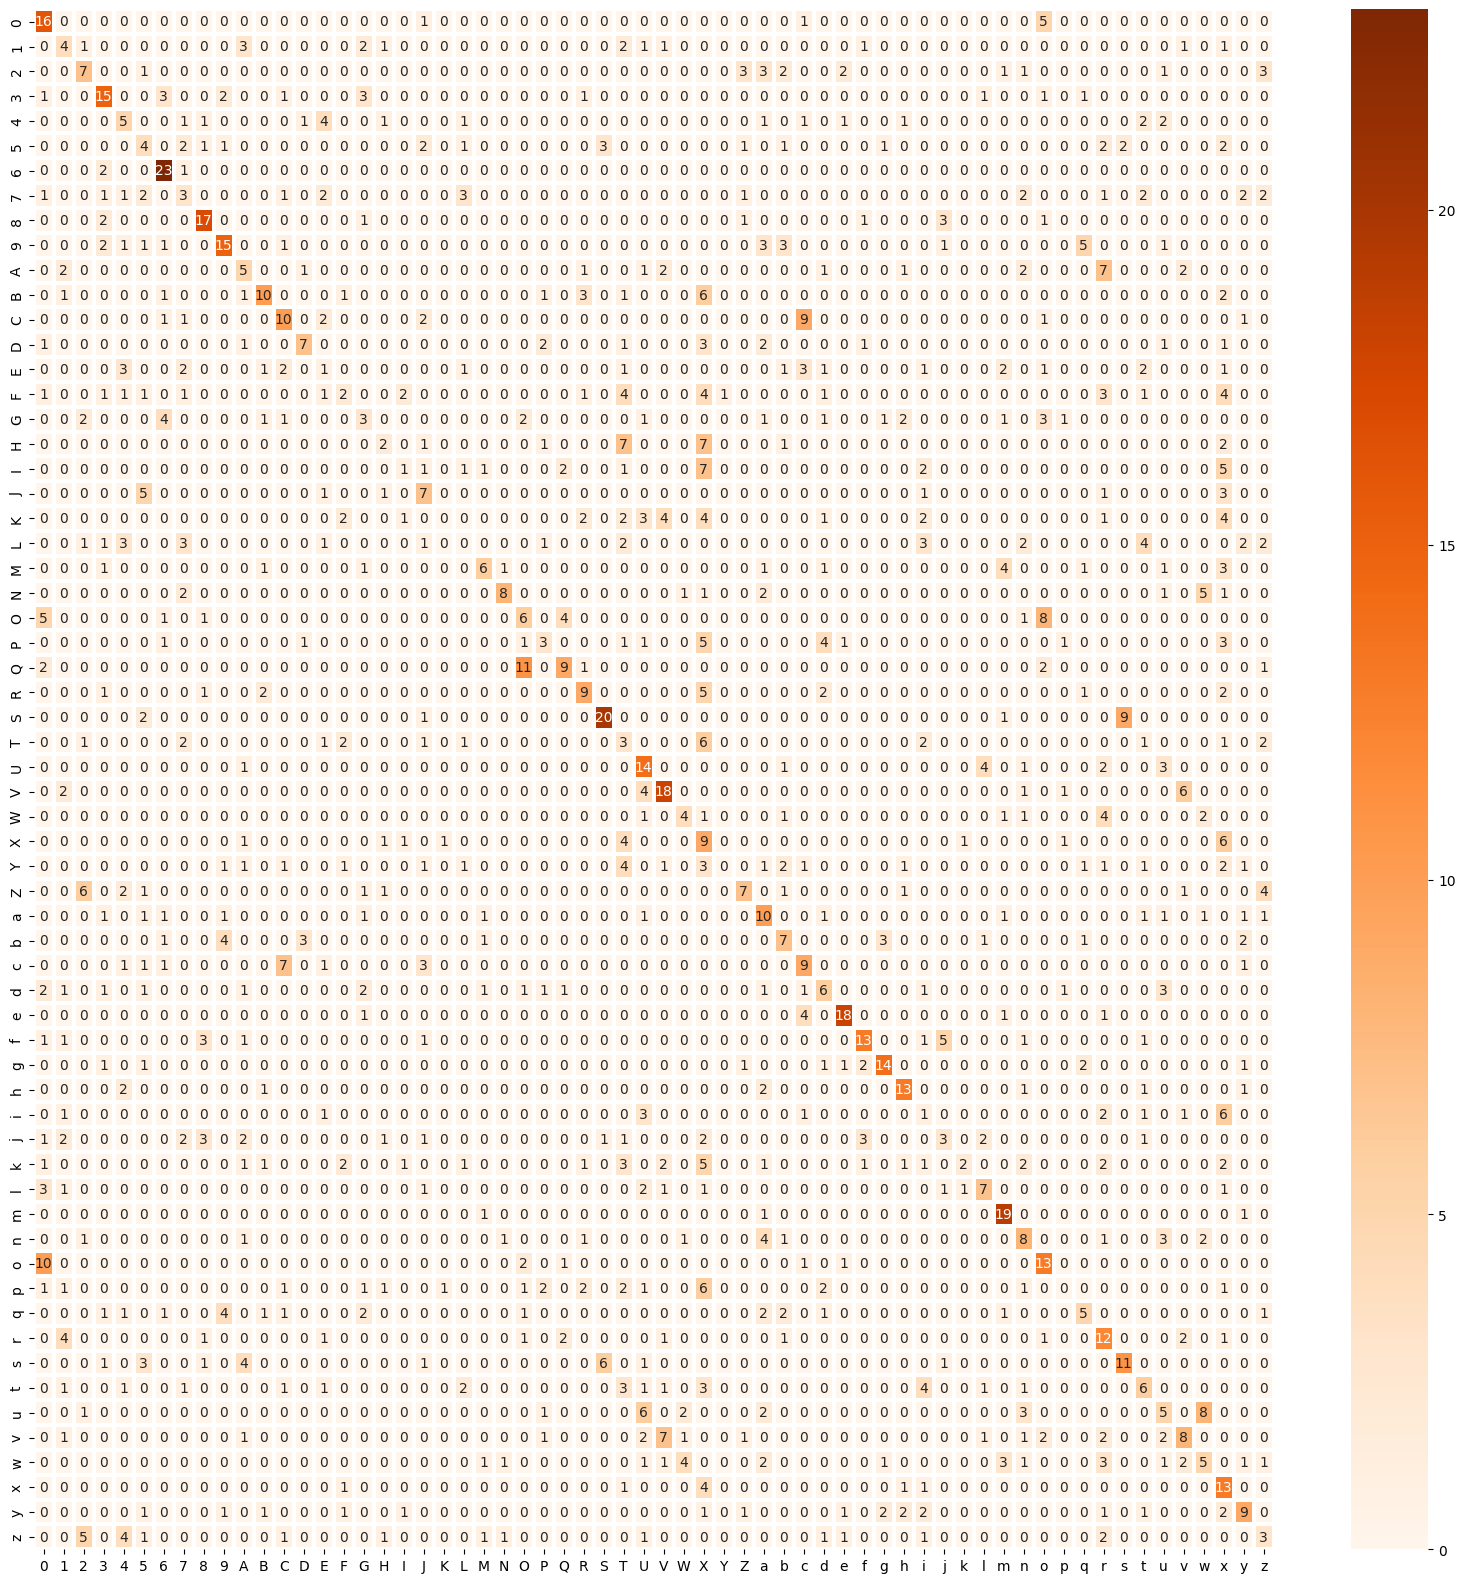

In [32]:
if __name__ == "__main__":
    cm=metrics.confusion_matrix(_targets,_preds)
    df_cm = DataFrame(cm, index=classes_names["val"], columns=classes_names["val"])
    from pandas import DataFrame
    import seaborn as sn
    plt.subplots(figsize=(20,20))
    sn.heatmap(df_cm,annot=True, fmt="d",linewidths=1.5,cmap="Oranges",)
    plt.savefig("images/CNNCell_uji_fft_confusion_matrix.png",  bbox_inches='tight', pad_inches=0)
    plt.show()